# Projet 10 : Détectez des faux billets avec Python

## Sommaire<a id='sommaire'></a>
<ol><li><a href="#nettoyage">Nettoyage et Analyse</a></li>
        <ol>
            <li><a href="#reglineaire">Traitement des valeurs manquantes avec la régression linéaire</a></li>
        </ol>
    <li><a href="#exploration">Exploration</a></li> 
        <ol>
            <li><a href="#univar">Analyses univariées</a></li>
            <li><a href="#testhyp">Test d'hypothèse</a></li>
        </ol>
    <li><a href="#modelisation">Modélisation</a></li> 
        <ol>
            <li><a href="#reglogsklearn">Régression Logistique avec sklearn</a></li>
            <li><a href="#reglogstatmodel">Régression Logistique avec statmodels</a></li>
            <li><a href="#kmeans">Kmeans</a></li>
        </ol>
    <li><a href="#evalfinal">Evaluation finale</a></li> 
        <ol>
            <li><a href="#fonctpred">Fonction de prédiction</a></li>
        </ol>
</ol>

## Import des librairies

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [251]:
from itertools import chain

In [252]:
from functions import backward_selected

In [253]:
from scipy.stats import levene, ttest_ind, shapiro, bartlett
from scipy.spatial.distance import mahalanobis
import scipy.stats as st

In [254]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [256]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [257]:
folder = 'D:/Data_Analyst_Projet/Projet 10/Données/'

In [258]:
# import des données
data = pd.read_csv(folder+'billets.csv', delimiter=';')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [259]:
data.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

<a id='nettoyage' ></a>
# Nettoyage et Analyse<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>
**Traitement des valeurs manquantes.**

In [260]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [261]:
data['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

**1000 vrais billets et 500 faux billets.**

In [262]:
# lignes contenant des valeurs nulles
data[data.isna().any(axis=1)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [263]:
# nombre de valeurs nulles
variable_nulle = data.isna().sum()[data.isna().sum()!=0].index[0]
nombre_valeurs_nulles = data.isna().sum()[data.isna().sum()!=0].values[0]

print(f"Il y a {nombre_valeurs_nulles} valeurs manquantes dans la variable {variable_nulle}.")

Il y a 37 valeurs manquantes dans la variable margin_low.


**Il y 37 valeurs manquantes sur 1500 lignes, uniquement pour la variable margin_low.**

**Nous allons les traiter en faisant une régression linéaire multiple en prenant margin_low comme variable cible, et en prédisant les valeurs où elles sont manquantes.**

<a id='reglineaire' ></a>
## Traitement des valeurs manquantes avec la régression linéaire<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

### Explication modèle de régression multiple

Le principe de la régression multiple, c'est qu'on va essayer d'expliquer une variable cible à partir de plusieurs variables explicatives.

**Le modèle de régression linéaire multiple suppose qu'il existe une relation linéaire entre la variable à expliquer et les variables explicatives :**
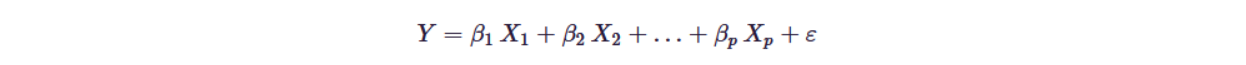

On cherche ensuite à **trouver la valeurs de chacun des paramètres B qui minimise la différence entre le modèle et la réalité grâce à la méthode des moindres carrés.** 

Mathématiquement, cela revient à calculer les estimateurs des moindres carrés ordinaires :

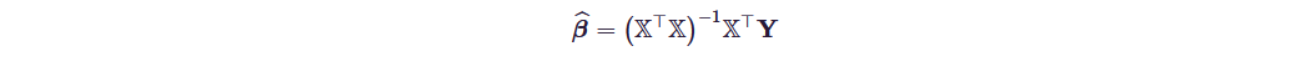

**Pour quantifier la qualité du modèle**, on utilise le **coefficient de détermination R²**, qui est le **taux de variation expliquée par le modèle.**

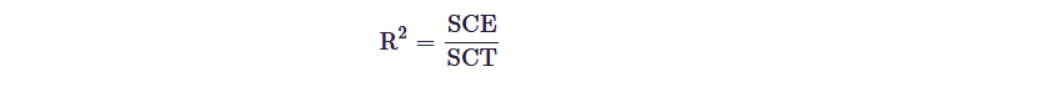

### Modèle de régression linéaire multiple

In [264]:
# data sans les valeurs manquantes
df = data.dropna()
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [265]:
# variables cible et explicatives
X = df.drop(columns=['is_genuine', 'margin_low'])
y = df['margin_low']

**J'enlève la variable 'is_genuine' car c'est la variable cible du modèle final.
Or, il ne serait pas rigoureux de l'utiliser en variable explicative dans un premier temps, puis en variable cible dans un second temps, cela créerait un biais et rendrait le modèle dépendant de la variable qu'il essait de prédire.**

In [266]:
# creation des jeux d'entrainement et de test
# pas forcément nécessaire pour de l'imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [267]:
# creation du modèle de régression linéaire
model = LinearRegression()

model.fit(X, y)

print(f"Le coefficient de détermination R² est de {model.score(X, y)}.")

Le coefficient de détermination R² est de 0.4773366973063957.


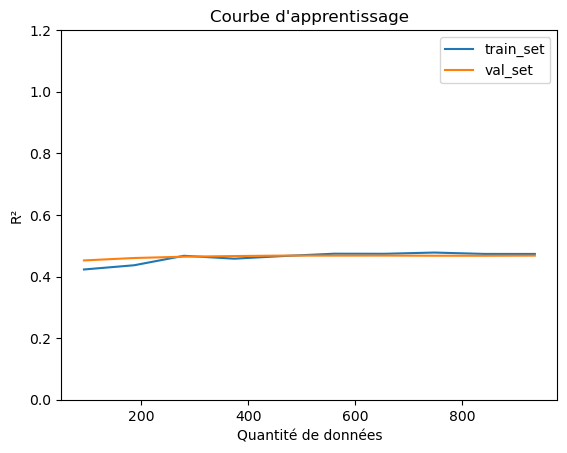

In [268]:
# courbe d'apprentissage du meilleur estimateur
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

**Pas d'écart entre le jeu d'entrainement et le jeu de validation.  
Le modèle généralise bien.**

In [269]:
# données à prédire
donnees_manquantes = data[data.isna().any(axis=1)].drop(columns=['is_genuine', 'margin_low'])
donnees_manquantes.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [270]:
# imputation des données manquantes par nos prédictions
data.loc[data.isna().any(axis=1),'margin_low'] = model.predict(donnees_manquantes)

In [271]:
# données billets avec les données prédites pour margin_low
data.loc[donnees_manquantes.index].head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36


## Régression multiple statsmodels

**Je recommence avec statsmdodels, pour comparer les 2 modèles et vérifier que :**
- Toutes les variables sont significatives pour la régression linéaire multiple, 
- Les résidus suivent une loi normale et vérifier,
- La colinéarité des variables avec les VIF.

In [205]:
X_sm = sm.add_constant(X)

# la creation des jeux d'entrainement et de test n'est pas obligatoire pour de l'imputation
# je décide donner le maximum de données au modèle et de ne pas créer de jeux d'entrainement et de test

results = sm.OLS(y, X_sm).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 24 Dec 2023   Prob (F-statistic):          2.60e-202
Time:                        12:37:59   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Les p-value sont toutes supérieurs à 0.05 (seuil de significativé standard) donc les variables sont représentatives.**

In [206]:
# nouvelles données manquantes pour faire les prédictions avec statsmodels, ajout de la colonne de biais
donnees_manquantes_sm = sm.add_constant(donnees_manquantes)
donnees_manquantes_sm.head()

,const,diagonal,height_left,height_right,margin_up,length
72,1.0,171.94,103.89,103.45,3.25,112.79
99,1.0,171.93,104.07,104.18,3.14,113.08
151,1.0,172.07,103.80,104.38,3.02,112.93
197,1.0,171.45,103.66,103.80,3.62,113.27
241,1.0,171.83,104.14,104.06,3.02,112.36


In [207]:
# comparaison predictions des 2 modèles
df_compar_model = pd.DataFrame()
df_compar_model['pred_sm'] = results.predict(donnees_manquantes_sm)
df_compar_model['pred_sklearn'] = model.predict(donnees_manquantes)
df_compar_model

,pred_sm,pred_sklearn
72,4.318525,4.318525
99,4.393668,4.393668
151,4.410457,4.410457
197,4.319014,4.319014
241,4.650617,4.650617
251,3.803308,3.803308
284,4.179736,4.179736
334,4.127442,4.127442
410,4.135034,4.135034
413,4.160539,4.160539


Les résultats sont identiques.

### Vérification de la normalité des résidus

In [208]:
shapiro(results.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

<Axes: ylabel='Count'>

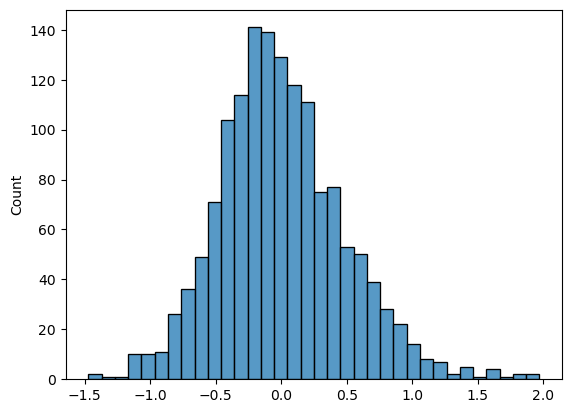

In [209]:
sns.histplot(results.resid)

**Le test de Shapiro-Wilk ne passe pas l'allure de la distribution est Gaussienne.  
On considère la distribution acceptable pour notre régression.**

### Vérification des VIF

**On calcul des VIF pour vérifier que les variables ne s'influencent pas entre elles.**

In [210]:
vif = [variance_inflation_factor(X_sm, i) for i in range(X_sm.shape[1])]
df_vif = pd.DataFrame(vif, index=X_sm.columns, columns=['VIF'])
df_vif

,VIF
const,590198.238883
diagonal,1.013613
height_left,1.138261
height_right,1.230115
margin_up,1.404404
length,1.576950


**Tous les coefficients VIF sont inférieurs à 10, donc les variables ne sont pas colinéaire.  
La régression linéaire remplie tous ses paramètres et est validée.**

<a id='exploration' ></a>
# Exploration<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

<a id='univar' ></a>
## Analyses univariées<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

### Répartition des variables explicatives pour les vrais et les faux billets

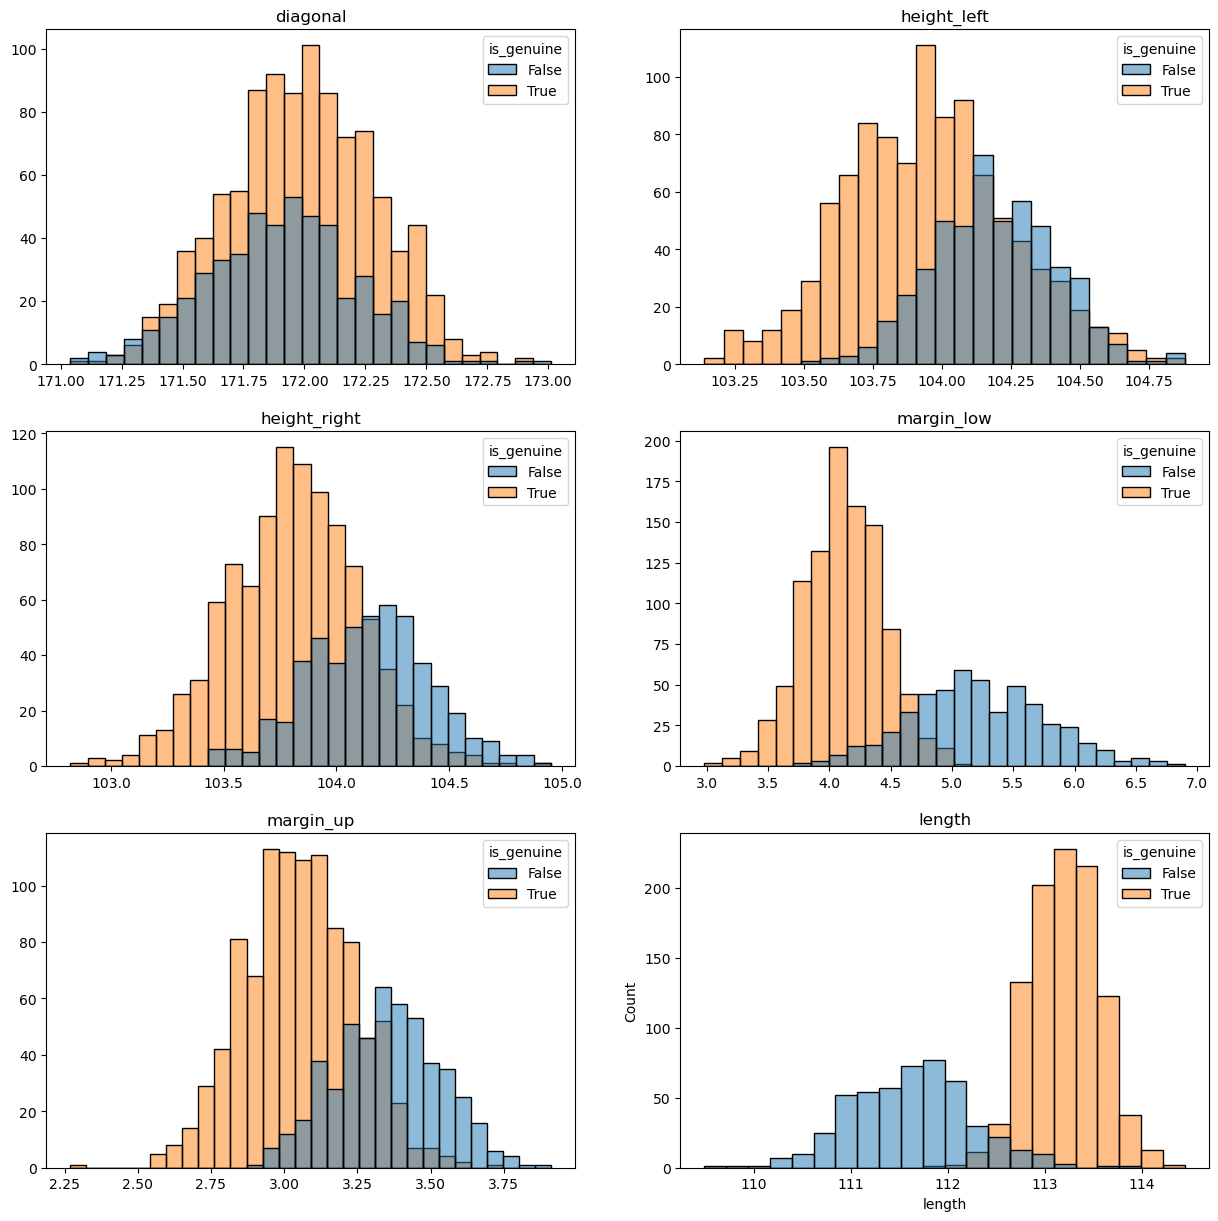

In [211]:
nb_col = data.drop(columns='is_genuine').shape[1]

plt.figure(figsize=(15, 20))

for col, i in zip(data.drop(columns='is_genuine').columns, range(nb_col)):
    plt.xlabel(None)
    plt.ylabel(None)
    plt.subplot(1+nb_col//2, 2, i+1)
    plt.title(col)
    sns.histplot(data=data, x=col, hue='is_genuine')

**Il semblerait que les distributions soient normales pour toutes les variables pour les vrais et faux billets.**

Il semblerait aussi que les **valeurs des variables soient significativement différentes pour les vrais et faux billets pour toutes les variables à part la variable 'diagonal'.**

Les **différences sont particulièrement marquées** pour les variables **margin_low, margin_up et length.**

<Axes: >

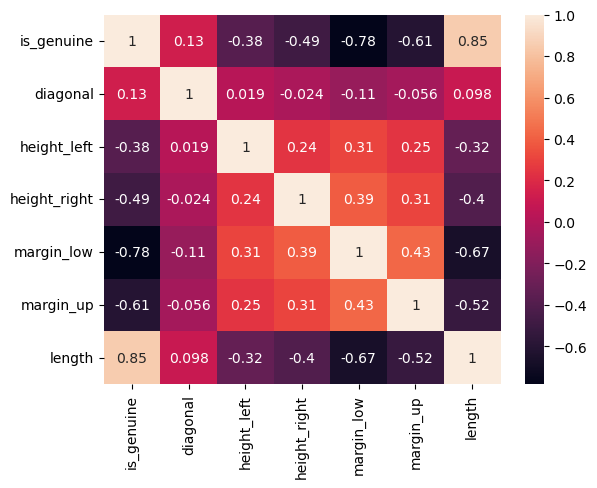

In [212]:
# matrice de corrélations
sns.heatmap(data.corr(), annot=True)

Cela confirme l'hypothèse du dessus, se sont surtout les **variables margin_low, margin_up et length qui sont corrélées à la variable cible.**

<a id='testhyp' ></a>
## Test d'hypothèse<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>
**Vérifier si les différences entre les vrais et les faux billets sont significatives pour chaque variable.**

On va réaliser un **test de student** qui va comparer la moyenne des 2 populations.

Les prérequis du test de student sont :
- La normalité de la distribution des 2 groupes.
- L'homogénéité des variances des 2 groupes.

In [213]:
data_true = data[data['is_genuine']==True]
data_false = data[data['is_genuine']==False]

### Normalité des distribution

In [214]:
for col in data.drop(columns='is_genuine').columns:
    print(col)
    print('Vrai billet')
    print(shapiro(data_true[col]))
    print('Faux billet')
    print(shapiro(data_false[col]))
    print('_'*100)

diagonal
Vrai billet
ShapiroResult(statistic=0.9980633854866028, pvalue=0.3102126121520996)
Faux billet
ShapiroResult(statistic=0.9974355697631836, pvalue=0.6387675404548645)
____________________________________________________________________________________________________
height_left
Vrai billet
ShapiroResult(statistic=0.9965806603431702, pvalue=0.028511906042695045)
Faux billet
ShapiroResult(statistic=0.9978764057159424, pvalue=0.7906213998794556)
____________________________________________________________________________________________________
height_right
Vrai billet
ShapiroResult(statistic=0.9985494613647461, pvalue=0.5872448086738586)
Faux billet
ShapiroResult(statistic=0.9979901313781738, pvalue=0.826613187789917)
____________________________________________________________________________________________________
margin_low
Vrai billet
ShapiroResult(statistic=0.9982866048812866, pvalue=0.4238669276237488)
Faux billet
ShapiroResult(statistic=0.9970296025276184, pvalue=0.50074

**Toutes les distributions sont considérées normales si on prends un alpha=0.01.**

### Homogénéité des variances

**Test de Bartlett** avec :

    H0 : Les variances des sous groupes sont égales
    H1 : Les variances des sous groupes sont différentes
    
alpha=1%

In [215]:
for col in data.drop(columns='is_genuine').columns:
    print(col)
    print(bartlett(data_true[col], data_false[col]))
    print('_'*100)

diagonal
BartlettResult(statistic=0.2987117108240286, pvalue=0.5846911917435405)
____________________________________________________________________________________________________
height_left
BartlettResult(statistic=53.27625211922919, pvalue=2.8978873571016144e-13)
____________________________________________________________________________________________________
height_right
BartlettResult(statistic=3.542589524124933, pvalue=0.05981201390578732)
____________________________________________________________________________________________________
margin_low
BartlettResult(statistic=216.88739037276582, pvalue=4.31861679806311e-49)
____________________________________________________________________________________________________
margin_up
BartlettResult(statistic=0.6698400851031404, pvalue=0.41310736619306765)
____________________________________________________________________________________________________
length
BartlettResult(statistic=207.23111965352825, pvalue=5.5204655214194

**Le test d'homogénéité des variances est passé pour 'diagonal', 'height_right' et 'margin_up'.**

On peut uniquement passer le test de student pour ces variables.

### Test de Student

In [216]:
for col in data.drop(columns='is_genuine').columns:
    print(col)
    print(ttest_ind(data_true[col], data_false[col]))
    print('_'*100)

diagonal
Ttest_indResult(statistic=5.184087524514633, pvalue=2.4668667372034535e-07)
____________________________________________________________________________________________________
height_left
Ttest_indResult(statistic=-15.8920858636644, pvalue=1.1269164017693944e-52)
____________________________________________________________________________________________________
height_right
Ttest_indResult(statistic=-21.470310019402618, pvalue=2.2708556903459502e-89)
____________________________________________________________________________________________________
margin_low
Ttest_indResult(statistic=-48.79265591014387, pvalue=8.919896249647e-312)
____________________________________________________________________________________________________
margin_up
Ttest_indResult(statistic=-29.50561631725463, pvalue=3.144530308715909e-151)
____________________________________________________________________________________________________
length
Ttest_indResult(statistic=62.262782927091045, pvalue

**On considère les moyennes des groupes (vrais et faux billets) statistiquement différentes pour toutes les variables.  
Mais le test n'est officiellement validé que pour les variables 'diagonal', 'height_right' et 'margin_up'.**

### Détermination des valeurs aberrantes avec le zscore

Détermination des valeurs aberrantes avec la méthode du zscore.  
Je calcule le zscore indépendamment pour les vrais billets et les faux billets étant donné qu'ils n'ont pas les mêmes caractéristiques.

In [217]:
data_zscore = data.copy()
data_true_zscore = data_true.copy()
data_false_zscore = data_false.copy()

In [218]:
# création d'une liste où on stocke les index des valeurs qui ne passe pas le test du zscore
index_zscore = []

for col in data.drop(columns='is_genuine').columns : 
    
    # données rejetées
    donnees_rejetee_true = list(data_true_zscore[abs(st.zscore(data_true_zscore[col]))>=3].index.values)
    donnees_rejetee_false = list(data_false_zscore[abs(st.zscore(data_false_zscore[col]))>=3].index.values)
    index_zscore.append(donnees_rejetee_true)
    index_zscore.append(donnees_rejetee_false)
    
    # données conservées
    data_true_zscore_en_cours = data_true_zscore[abs(st.zscore(data_true_zscore[col]))<3]
    data_false_zscore_en_cours = data_false_zscore[abs(st.zscore(data_false_zscore[col]))<3]
    data_zscore = pd.concat((data_true_zscore_en_cours, data_false_zscore_en_cours), axis=0)
    print(f"Variable {col}")
    print(f"{data_true.shape[0] - data_true_zscore_en_cours.shape[0]} vrais billets considérés aberrants par le zscore.")
    print(f"{data_false.shape[0] - data_false_zscore_en_cours.shape[0]} faux billets considérés aberrants par le zscore.")
    print(f"Soit {data.shape[0] - data_zscore.shape[0]} billets considérés aberrants au total")
    print('_'*100)

index_zscore = list(chain(*index_zscore))

Variable diagonal
3 vrais billets considérés aberrants par le zscore.
2 faux billets considérés aberrants par le zscore.
Soit 5 billets considérés aberrants au total
____________________________________________________________________________________________________
Variable height_left
1 vrais billets considérés aberrants par le zscore.
2 faux billets considérés aberrants par le zscore.
Soit 3 billets considérés aberrants au total
____________________________________________________________________________________________________
Variable height_right
4 vrais billets considérés aberrants par le zscore.
0 faux billets considérés aberrants par le zscore.
Soit 4 billets considérés aberrants au total
____________________________________________________________________________________________________
Variable margin_low
3 vrais billets considérés aberrants par le zscore.
1 faux billets considérés aberrants par le zscore.
Soit 4 billets considérés aberrants au total
________________________

**Au total, serait ferait 26 valeurs considérées aberrantes avec la méthodes du zscore.**

**Pour la modélisation, on conserve toutes les valeurs car l'algorithme prédictif donne de meilleur résultat avec la totalité des billets.**

<a id='modelisation' ></a>
# Modélisation<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

## Présentation de la régression logistique

**La régression logistique est un modèle statistique utilisé pour modéliser la probabilité d'un événement binaire en fonction d'un ensemble de variables indépendantes.**

**Elle permet de prédire en fonction d'un ensemble de donnée, si une valeur appartient à une classe ou à une autre.**

**Elle fonctionne de la même manière que la régression linéaire multiple, à la différence que notre équation : 
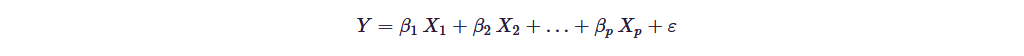
va passer dans la fonction logistique (sigmoid) pour donner une probabilité d'appartenir à une classe ou à une autre.**

**Voici donc l'équation finale de notre fonction logistique :**

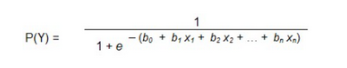

**En fonction des valeurs des variables explicatives, on applique la probabilité à la variable cible d'être égale à 0 ou 1.**

**Dans notre cas Vrai ou Faux.**

<a id='reglogsklearn' ></a>
## Régression Logistique avec sklearn<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [219]:
data['is_genuine'] = data['is_genuine'].replace([True, False], [1,0])

In [220]:
# cible et features
# features standardisées pour afficher la courbe d'apprentissage
X = StandardScaler().fit_transform(data.drop(columns='is_genuine'))
y = data['is_genuine']

In [221]:
# création des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [222]:
print(y_train.value_counts())
print(y_test.value_counts())

1    798
0    402
Name: is_genuine, dtype: int64
1    202
0     98
Name: is_genuine, dtype: int64


In [223]:
# creation du modèle de régression logistique
model = LogisticRegression()

model.fit(X_train, y_train)

print(f"L'accuracy (exactitude) est de {model.score(X_test, y_test)}")

L'accuracy (exactitude) est de 0.9966666666666667


### Evaluation

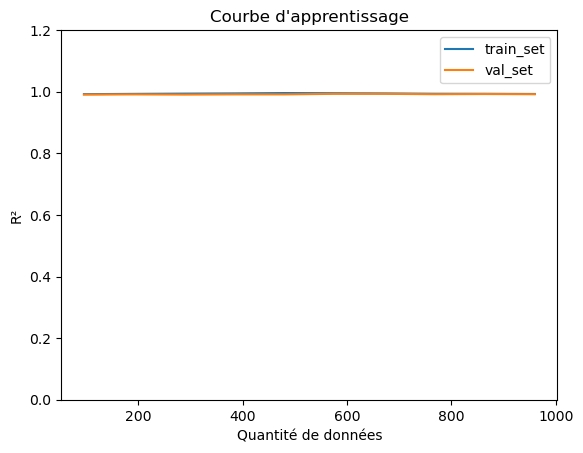

In [224]:
# courbe d'apprentissage du meilleur estimateur, on utilise le score F1
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='f1')

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

**Les jeux d'entrainement et de validation ont une accuracy similaire proche de 1.  
Le modèle n'est donc pas en sur-apprentissage et est capable de généraliser.**

#### Matrice de confusion

In [225]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,0,202


In [226]:
# vérification du faux positif
test_pred = pd.DataFrame(y_test)

test_pred['y_pred'] = y_pred

test_pred.loc[(test_pred['is_genuine']==0)&(test_pred['y_pred']==1)]

,is_genuine,y_pred
1407,0,1


#### Classification report

In [227]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



**On retrouve ici toutes les métriques importantes d'un algorithme de classification, nous allons les voir plus en détail avec l'analyse de la courbe ROC.**

#### Courbe ROC

**La courbe ROC, est un outil utilisé pour évaluer les performances d'un modèle de classification binaire, tel qu'un modèle de machine learning qui doit décider entre deux classes, comme "vrai" et "faux".**

**Cet outil permet de visualiser la capacité d'un modèle à discriminer entre ces deux classes en fonction de différents seuils de classification.
Le seuil de classification correspond à la probabilité à partir de laquelle on considère qu'une valeurs appartient à une classe ou à une autre. Par défaut ce seuil est de 0.5**

**La courbe ROC représente les vrais positifs (sensibilité) en fonction des faux positifs (anti spécificité) avec différentes valeurs de seuils.**

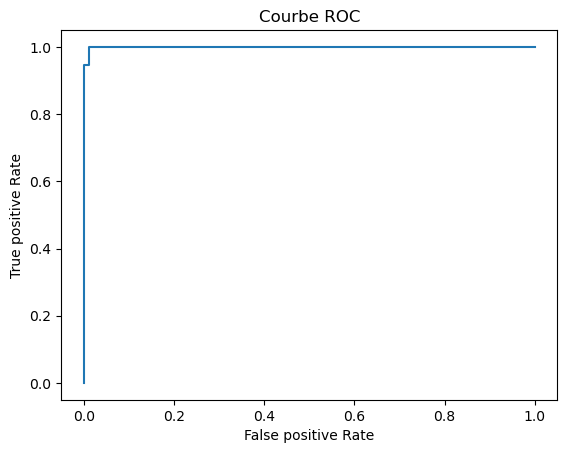

In [228]:
# probabilité pour chaque observation de X_test d'appartenir à la classe 1
y_pred_prob = model.predict_proba(X_test)[:,1]

# courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.title("Courbe ROC")
plt.xlabel("False positive Rate")
plt.ylabel("True positive Rate")
plt.plot(fpr, tpr);

In [229]:
# AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"L'AUC score est de {auc_score.round(4)}, cet indicateur correspond à l'aire, plus l'aire est élevée, plus le modèle est qualitatif.")

L'AUC score est de 0.9994, cet indicateur correspond à l'aire, plus l'aire est élevée, plus le modèle est qualitatif.


#### Incidence du seuil sur la sensibilité et la spécificité et détermination du meilleur seuil

**On détermine le meilleur seuil en regardant ou la différence entre le taux de sensibilité et l'anti spécificité est maximiser.**

In [230]:
seuils = np.linspace(0, 1, 20)
anti_specificitys = []
sensitivitys = []

for seuil in seuils :
    
    y_pred = y_pred_prob >= seuil
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    confusion_matrice = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                    columns = ['Prédit Faux', 'Prédit Vrai'], index = ['Faux', 'Vrai'])
    
    # metrique de classification des faux billets, taux de faux negatifs
    # probabilité lié aux vrais négatifs
    specificity = tn/(tn+fp)
    # taux de faux billets mal classés, taux de faux positifs
    anti_specificity = 1 - specificity

    # metrique de classification des vrais billets
    # probabilité lié aux vrais positifs
    sensitivity = tp/(tp+fn)
    
    anti_specificitys.append(anti_specificity)
    sensitivitys.append(sensitivity)

In [231]:
tableau_seuil = pd.DataFrame([seuils, sensitivitys, anti_specificitys],
            index=['Seuil', 'Taux de vrais positifs', 'Taux de faux positifs']).T
tableau_seuil

,Seuil,Taux de vrais positifs,Taux de faux positifs
0,0.000000,1.000000,1.000000
1,0.052632,1.000000,0.071429
2,0.105263,1.000000,0.051020
3,0.157895,1.000000,0.040816
4,0.210526,1.000000,0.030612
5,0.263158,1.000000,0.020408
6,0.315789,1.000000,0.020408
7,0.368421,1.000000,0.020408
8,0.421053,1.000000,0.010204
9,0.473684,1.000000,0.010204


**Les seuils entre 0.421 et 0.684 offres les meilleurs résultats.  
Le taux de vrais positifs (1.0) est maximum tandis que le taux de faux positifs est minimum (0.01).**

**La différence entre les 2 est maximisée.**

**Le taux initial à 0.5 est donc adapté.**

<a id='reglogstatmodel' ></a>
## Régression Logistique avec statmodels<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [232]:
# df pour garder le nom des colonnes
X_stat = pd.DataFrame(data.drop(columns='is_genuine'), columns=data.drop(columns='is_genuine').columns)

# ajout de la constante
X_stat = sm.add_constant(X_stat)

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=1)

model = sm.Logit(y_train, X_train)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.030424
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Sun, 24 Dec 2023   Pseudo R-squ.:                  0.9523
Time:                        12:38:04   Log-Likelihood:                -36.509
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                9.132e-312
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -215.0874    261.241     -0.823      0.410    -727.111     296.936
diagonal         0.1374      1.174      0.117      0.907      -2.163       2.438
height_left     -1.7707      1.158     -1.529      0.126      -4.040       0.499
height_right    -1.9413      1.077     -1.803      0.071      -4.051       0.169
margin_low      -5.7866      1.017     -5.691      0.000      -7.779      -3.794
margin_up      -10.3765      2.326     -4.461      0.000     -14.935      -5.818
length           5.6649      0.887      6.390      0.000       3.927       7.402
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Certaines variables ne sont pas significatives pour le modèle, on va enlever la variable qui est la moins significative, ici 'diagonal', avec sa p-value de 0.907, puis relancer le modèle et vérifier la significativité des variable restante jusqu'à qu'elles soient toutes significatives.**

In [233]:
# df pour garder le nom des colonnes
X_stat = pd.DataFrame(data.drop(columns=['is_genuine', 'diagonal']), columns=data.drop(columns=['is_genuine', 'diagonal']).columns)

# ajout de la constante
X_stat = sm.add_constant(X_stat)

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=1)

model = sm.Logit(y_train, X_train)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.030430
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Sun, 24 Dec 2023   Pseudo R-squ.:                  0.9523
Time:                        12:38:04   Log-Likelihood:                -36.516
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -191.3113    163.815     -1.168      0.243    -512.383     129.761
height_left     -1.7684      1.158     -1.527      0.127      -4.038       0.501
height_right    -1.9583      1.064     -1.841      0.066      -4.043       0.127
margin_low      -5.8274      0.961     -6.064      0.000      -7.711      -3.944
margin_up      -10.4045      2.318     -4.488      0.000     -14.949      -5.860
length           5.6796      0.881      6.446      0.000       3.953       7.407
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [234]:
# df pour garder le nom des colonnes
X_stat = pd.DataFrame(data.drop(columns=['is_genuine', 'diagonal', 'height_left']), columns=data.drop(columns=['is_genuine', 'diagonal', 'height_left']).columns)

# ajout de la constante
X_stat = sm.add_constant(X_stat)

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=1)

model = sm.Logit(y_train, X_train)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.031437
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Sun, 24 Dec 2023   Pseudo R-squ.:                  0.9507
Time:                        12:38:04   Log-Likelihood:                -37.724
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -326.1464    144.416     -2.258      0.024    -609.197     -43.096
height_right    -2.4191      1.076     -2.249      0.025      -4.528      -0.311
margin_low      -6.0344      0.968     -6.236      0.000      -7.931      -4.138
margin_up      -10.4453      2.286     -4.569      0.000     -14.926      -5.965
length           5.6778      0.857      6.621      0.000       3.997       7.358
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Après plusieurs itérations, les variables significatives pour le modèle seront height_right, margin_low, margin_up, length.**

In [235]:
# VIF
vif = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif = pd.DataFrame(vif, index=X_train.columns, columns=['VIF'])
df_vif

,VIF
const,187569.205220
height_right,1.244908
margin_low,1.958859
margin_up,1.372698
length,2.135762


In [236]:
# prédiction
y_pred = results.predict(X_test).round().astype('int')

test_pred = pd.concat((y_test, y_pred), axis=1)

crosstab = pd.crosstab(test_pred['is_genuine'], test_pred[0])

crosstab.index = ['Faux', 'Vrai']
crosstab.columns = ['Prédit Faux', 'Prédit Vrai']

crosstab

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,0,202


<a id='kmeans' ></a>
## Kmeans<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

**Le kmeans est un algorithme de clustering non supervisé.
Cela signifie qu'on entraine l'algorithme sans lui indiquer les vrais des faux billets (les étiquettes), c'est l'algorithme qui va déterminer les 2 groupes en se basant uniquement sur les similitudes entre les valeurs des variables**

**Il permet de partitionner un jeu de données en groupe partageant des caractéristiques communes.**

**Ici, on va partitioner le jeu de données en 2 groupes et tenter de départager les vrais des faux billets.**

In [237]:
data2 = data.copy()
data2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [238]:
# création de l'estimateur
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=20)

kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto', random_state=20)

In [239]:
# coordonnées des centroides

centroides = kmeans.cluster_centers_

# clusters de l'echantillon

data2['clusters_kmeans'] = kmeans.labels_

In [240]:
# encodage de la variable binaire
data2['is_genuine'] = data2['is_genuine'].replace([True, False], [1,0])

In [241]:
data2['is_genuine'].value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

In [242]:
# creation de la matrice de confusion avec la méthode du kmeans
pd.DataFrame(confusion_matrix(data2['is_genuine'], data2['clusters_kmeans']), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,487,13
Vrai,10,990


**23 billets sont mals classés.  
La Régression Logistique donne de meilleur résultat. C'est ce modèle qu'on conserve.**

In [243]:
print(classification_report(data2['is_genuine'], data2['clusters_kmeans']))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       500
           1       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



<a id='evalfinal' ></a>
## Evaluation finale<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [1]:
data_prod = pd.read_csv(folder+'billets_production.csv', delimiter=',')
data_prod.head()

NameError: name 'pd' is not defined

<a id='fonctpred' ></a>
### Fonction de prédiction<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [245]:
def prediction(data_prod):
    
    # mise au format de mon modèle final
    
    data_prod_pred = data_prod.copy()

    # ajout de la constante
    X_eval = sm.add_constant(data_prod_pred)

    # mise au format du modèle en gardant les colonnes significatives utilisées pour le modèle final
    X_eval = X_eval[results.model.exog_names]
    
    # prédiction de la nature des billets (vrai ou faux) en fonction de leurs caractéristiques
    data_prod_pred['prediction_billet'] = results.predict(X_eval).round().astype('int').replace([0,1], ['Faux', 'Vrai'])
    
    # message à afficher 
    
    for billet, prediction in zip(data_prod_pred['id'], data_prod_pred['prediction_billet']):
        if prediction == 'Vrai':
            print(f"C'est bon, le billet {billet} est un {prediction} !")
        if prediction == 'Faux':
            print(f"Attention, le billet {billet} est un {prediction} !")    
            
    return data_prod_pred

In [246]:
prediction(data_prod)

Attention, le billet A_1 est un Faux !
Attention, le billet A_2 est un Faux !
Attention, le billet A_3 est un Faux !
C'est bon, le billet A_4 est un Vrai !
C'est bon, le billet A_5 est un Vrai !


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction_billet
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai


In [247]:
data_test = pd.read_csv(folder+"billets_test.csv")

In [248]:
prediction(data_test)

C'est bon, le billet B_1 est un Vrai !
Attention, le billet B_2 est un Faux !
C'est bon, le billet B_3 est un Vrai !
Attention, le billet B_4 est un Faux !
Attention, le billet B_5 est un Faux !


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction_billet
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,Vrai
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,Faux
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,Vrai
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,Faux
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,Faux


# Conclusion

**C'est le modèle de Régression Logistique qui donne les meilleurs résultats avec une accuracy à plus de 99%.  
De plus, c'est un modèle assez simple et interprétable contrairement à d'autres modèles plus complexes qui peuvent être plus difficile à interpréter.**

# Bonus : test d'autres modèles

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

## KNN

In [102]:
# cible et features, features standardisées pour afficher la courbe d'apprentissage
X = data.drop(columns='is_genuine')
y = data['is_genuine']

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [103]:
# creation du modèle de régression logistique
scores = []

for k in [5, 10, 15, 20, 30, 40]:
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    
    scores.append(score)

In [104]:
scores

[0.9966666666666667,
 0.9966666666666667,
 0.9966666666666667,
 0.9966666666666667,
 0.9966666666666667,
 0.9933333333333333]

In [105]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,1,201


## RandomForest

In [106]:
# creation du modèle de régression logistique
model = RandomForestClassifier()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9933333333333333

In [107]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,1,201


## SVC

In [108]:
# creation du modèle de SVM
model = LinearSVC()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.99

In [109]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,98,0
Vrai,3,199
